## Change Point Detection for Viral Events in British History
#### Using House of Commons parliamentary documents in the 19th century
Sabrina Peng - CS 7391, Spring 2020

## I. Preprocessing

In [ ]:
import pandas as pd
import numpy as np
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, TfidfModel
import random, math
from statistics import mode
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm
import ruptures as rpt

In [ ]:
df = pd.read_csv("hansard_justnine_12192019.csv")
hansard = df.copy()

In [ ]:
speechdates = list(hansard["speechdate"])
speechyears = [date[:4] for date in speechdates]
hansard["speechyear"] = speechyears
unique_speech_years = sorted(list(hansard["speechyear"].unique()))

In [ ]:
# select 100 random samples from each year to create a subset of data

def performRandomSample(lower, upper, num):
    toReturn = []
    possibleVals = list(range(lower, upper))
    random.shuffle(possibleVals)
    while len(toReturn) != num:
        toReturn.append(possibleVals[-1])
        possibleVals.pop()
    return toReturn
    
# this it the line to change, if needed!
samplesPerYear = 100
years = hansard["speechyear"].unique()
indices = np.zeros((len(hansard), 1))
selection = []
for year in years:
    yearSubset = hansard[hansard["speechyear"] == year]
    sample = performRandomSample(0, min(len(yearSubset)-1, samplesPerYear), min(len(yearSubset)-1, samplesPerYear))
    for idx in sample:
        selection.append(yearSubset.iloc[idx, :])
        
dataSubset = pd.DataFrame(selection, columns = hansard.columns)

In [5]:
# helper tools and structures for preprocessing

In [6]:
swlist = set(stopwords.words("english"))
delchars = ''.join(c for c in map(chr, range(256)) if not c.isalnum())
delchars += '—'
govwords = ["attorney", "court",  "attorney", "money",
                "gentleman", "noble", "respect", "sir",
                "hope", "question", "feeling", "doubt", "general",
                "subject", "found", "statement", "parliament",
                "prepared", "law", "authority", "majority",
                "importance", "thought", "land", "leave", "measure",
                "policy", "speech", "weight", "liberty", "possession",
                "justice", "word", "fact", "treat", "highest", "argument",
                "concerned", "late", "bad", "discussion", "owing",
                "objection", "disposed", "expect", "system", "limited",
                "display", "delay", "powerful", "anxious", "forward",
                "interest", "loss", "reason", "intended", "chancellor",
                "grant", "earl", "engaged", "information", "responsible",
                "attention", "long", "real", "facts", "operation", "opposed",
                "sentence", "judicial", "majesty", "established", "immediately",
                "county", "considerable", "action", "united", "confined", "legal",
                "received", "tribunal", "foreign", "ground", "result",
                "confess", "discretion", "continue", "proposition", "agreed",
                "fully", "share", "possess", "pledge", "cabinet", "supremacy",
                "promise", "agree", "sense", "commit", "judgment", "credit",
                "possessed", "full", "title", "president", "minister",
                "constitutional", "remove", "withdraw", "intelligence", "procedure",
                "understanding", "knowledge", "providing", "officer", "guarantee",
                "cross", "prevent", "john", "chairman", "proceeding", "reform",
                "organization", "nation", "civil", "colonel", "prime",
                "good", "pay", "salary",
                "time", "words", "change", "rule", "plan", "motion",
                "examination", "vote", "perjury", "opposition", "kind",
                "friend", "member", "committee", "investigation",
                "board", "inquiry", "present", "lord", "government",
                "special", "appeal", "case", "bonus", "advance", "deal", "tax"]

govwords = set(govwords)
swlist = swlist | govwords

In [7]:
adjective = ['JJ', 'JJR', 'JJS']
verb = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
noun = ['NN', 'NNP', 'NNPS', 'NNS',]
adverb = ['RB', 'RBR', 'RBS']
# allowed_tag_list = adjective + verb + noun + adverb
allowed_tag_list = verb + noun

In [8]:
# WordNet POS tags are: NOUN = 'n', ADJ = 's', VERB = 'v', ADV = 'r', ADJ_SAT = 'a'
# Descriptions (c) https://web.stanford.edu/~jurafsky/slp3/10.pdf
tag_map = {
    'CC':None, # coordin. conjunction (and, but, or)  
    'CD':wn.NOUN, # cardinal number (one, two)             
    'DT':None, # determiner (a, the)                    
    'EX':wn.ADV, # existential ‘there’ (there)           
    'FW':None, # foreign word (mea culpa)             
    'IN':wn.ADV, # preposition/sub-conj (of, in, by)   
    'JJ':wn.ADJ, # adjective (yellow)                  
    'JJR':wn.ADJ, # adj., comparative (bigger)          
    'JJS':wn.ADJ, # adj., superlative (wildest)           
    'LS':None, # list item marker (1, 2, One)          
    'MD':None, # modal (can, should)                    
    'NN':wn.NOUN, # noun, sing. or mass (llama)          
    'NNS':wn.NOUN, # noun, plural (llamas)                  
    'NNP':wn.NOUN, # proper noun, sing. (IBM)              
    'NNPS':wn.NOUN, # proper noun, plural (Carolinas)
    'PDT':wn.ADJ, # predeterminer (all, both)            
    'POS':None, # possessive ending (’s )               
    'PRP':None, # personal pronoun (I, you, he)     
    'PRP$':None, # possessive pronoun (your, one’s)    
    'RB':wn.ADV, # adverb (quickly, never)            
    'RBR':wn.ADV, # adverb, comparative (faster)        
    'RBS':wn.ADV, # adverb, superlative (fastest)     
    'RP':wn.ADJ, # particle (up, off)
    'SYM':None, # symbol (+,%, &)
    'TO':None, # “to” (to)
    'UH':None, # interjection (ah, oops)
    'VB':wn.VERB, # verb base form (eat)
    'VBD':wn.VERB, # verb past tense (ate)
    'VBG':wn.VERB, # verb gerund (eating)
    'VBN':wn.VERB, # verb past participle (eaten)
    'VBP':wn.VERB, # verb non-3sg pres (eat)
    'VBZ':wn.VERB, # verb 3sg pres (eats)
    'WDT':None, # wh-determiner (which, that)
    'WP':None, # wh-pronoun (what, who)
    'WP$':None, # possessive (wh- whose)
    'WRB':None, # wh-adverb (how, where)
    '$':None, #  dollar sign ($)
    '#':None, # pound sign (#)
    '“':None, # left quote (‘ or “)
    '”':None, # right quote (’ or ”)
    '(':None, # left parenthesis ([, (, {, <)
    ')':None, # right parenthesis (], ), }, >)
    ',':None, # comma (,)
    '.':None, # sentence-final punc (. ! ?)
    ':':None # mid-sentence punc (: ; ... – -)
}

In [9]:
speech_to_year = {}
for index, row in dataSubset.iterrows():
    speech_to_year[row['speech_id']] = row['speechyear']

In [10]:
all_sentences = list(dataSubset["text"])
lemmatizer = WordNetLemmatizer()
speech_sent_dict = {}

In [11]:
for speech in tqdm(dataSubset.speech_id.unique()):
    sentences = list(dataSubset[dataSubset["speech_id"] == speech]["text"])
    sentences = [word_tokenize(sent.lower()) for sent in sentences]
    new_sentences = []
    for sent in sentences:
        # strip punctuation and filter
        sent = [token.translate(str.maketrans('', '', delchars)) for token in sent]
        sent = [token for token in sent if len(token) > 1 and token not in swlist]
        
        # get part of speech, both pos and wordnet pos
        pos = pos_tag(sent)
        dic = dict(pos)
        
        wn_pos = [(tup[0], tag_map[tup[1]]) for tup in pos]
        dic1 = dict(wn_pos)
        
        new_sent = [lemmatizer.lemmatize(token, dic1[token]) for token in sent if dic[token] in allowed_tag_list]
        new_sent = [token for token in new_sent if token not in swlist]
        new_sentences.append(new_sent)
    
    tokens = [token for sent in new_sentences for token in sent]
    speech_sent_dict[speech] = tokens

100%|██████████| 698/698 [00:14<00:00, 49.34it/s]


In [12]:
docs = list(speech_sent_dict.keys())
all_tokens = speech_sent_dict.values()

In [13]:
# get predominant year for each speech
doc_years = {}
for doc in docs:
    doc_years[doc] = mode(dataSubset[dataSubset["speech_id"] == doc]["speechyear"])
    
# get number of speeches per year for normalization purposes
year_docs = {}
for year in years:
    docs_per_year = [k for k,v in doc_years.items() if v == year]
    year_docs[year] = len(docs_per_year)

## II. Approach: LDA Topic Modelling (Entire Period)

In [14]:
dictionary = Dictionary(all_tokens)
corpus = [dictionary.doc2bow(doc) for doc in all_tokens]

In [50]:
# create models for various numbers of topics
model_50 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=50, alpha='auto', minimum_probability=0.0001)
model_100 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=100, alpha='auto', minimum_probability=0.0001)
model_200 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=200, alpha='auto', minimum_probability=0.0001)
models = [model_50, model_100, model_200]

In [51]:
for topic_id in range(0, 3):
    print(model_50.show_topic(topic_id))

[('country', 0.022069998), ('lordship', 0.013048694), ('say', 0.009294018), ('make', 0.008531629), ('state', 0.008090238), ('year', 0.007941063), ('take', 0.0073636523), ('part', 0.0063455757), ('power', 0.0062559023), ('place', 0.00618898)]
[('take', 0.010265086), ('address', 0.009154273), ('bill', 0.008974625), ('house', 0.008611014), ('country', 0.008446802), ('make', 0.008068586), ('act', 0.0076301405), ('move', 0.0066241818), ('office', 0.006485043), ('say', 0.00640258)]
[('call', 0.009760511), ('state', 0.008932951), ('point', 0.008742162), ('opinion', 0.00841666), ('house', 0.008187151), ('say', 0.008100738), ('lordship', 0.007969486), ('duty', 0.007346003), ('give', 0.006910437), ('make', 0.0067833094)]


In [52]:
for topic_id in range(0, 3):
    print(model_100.show_topic(topic_id))

[('lordship', 0.018034955), ('country', 0.016872916), ('house', 0.014233825), ('petition', 0.012898132), ('state', 0.011012124), ('say', 0.010419503), ('take', 0.010030159), ('make', 0.0075638625), ('lay', 0.007123525), ('place', 0.0070470464)]
[('house', 0.012821349), ('country', 0.012088228), ('lordship', 0.0120745925), ('railway', 0.009794887), ('make', 0.00911959), ('year', 0.0079733245), ('state', 0.006925991), ('power', 0.0064384243), ('say', 0.006424138), ('place', 0.0062059993)]
[('say', 0.012336856), ('state', 0.012171668), ('make', 0.01041511), ('property', 0.009317616), ('take', 0.008125252), ('think', 0.00804582), ('tithe', 0.007890663), ('produce', 0.0076125637), ('house', 0.007610532), ('bill', 0.0073445085)]


In [53]:
for topic_id in range(0, 3):
    print(model_200.show_topic(topic_id))

[('country', 0.020382103), ('say', 0.018662075), ('lordship', 0.013712893), ('ireland', 0.009936328), ('house', 0.009254415), ('year', 0.0072490624), ('power', 0.0068059918), ('make', 0.0066859378), ('state', 0.0066851773), ('take', 0.006248539)]
[('house', 0.025327364), ('business', 0.0141106555), ('state', 0.013418128), ('adjournment', 0.012781762), ('society', 0.010390463), ('act', 0.010033576), ('make', 0.009618428), ('say', 0.009280828), ('lordship', 0.009249073), ('give', 0.008683054)]
[('bankruptcy', 0.0155103505), ('lordship', 0.015487171), ('country', 0.012143242), ('bill', 0.01153912), ('make', 0.009225102), ('propose', 0.008745734), ('year', 0.008726659), ('relate', 0.008187921), ('say', 0.007444478), ('consider', 0.006929187)]


Visual inspection of topic word-representations show that topics may have considerable overlap and better topic representations should be created by filtering out common words across all topics (done later).

### Sum of Document Weighted Probabilities Plots for Specified Topics for LDA-50 and LDA-100
Based on 100 sample sentences from each year - number of documents (speeches) per year is variable.

In [54]:
# get documents that are associated with each topic
def get_doc_and_topic_data(model):  
    num_topics = len(model.get_topics())
    
    # topics for each document
    doc_topics = []
    for corp in corpus:
        vector = model[corp]
        topics = [topic for (topic, prob) in vector]
        doc_topics.append(vector)

    # documents for each topic
    topic_docs = []
    for t in range(0, num_topics):
        topic = []

        # for each document
        for idx, doc_topic in enumerate(doc_topics):
            # topics for that document
            topics = [topic for (topic, prob) in doc_topic]
            for tup in doc_topic:
                if t == tup[0]:
                    # append that document and probability
                    topic.append((idx, tup[1]))
        topic_docs.append(topic)
    
    return topic_docs

In [55]:
# plots number of documents (speeches) for a given topic over time based on speech dates
def plot_frequency(topic_docs, doc_years, docs, unique_speech_years, num_topics):    
    for topic_num in range(0, num_topics):
        doc_year = dict.fromkeys(unique_speech_years, 0)

        for doc_tup in topic_docs[topic_num]:
            year = doc_years[docs[doc_tup[0]]]
            doc_year[year] += 1
            
        years = list(doc_year.keys())
        xvals = [year for year in years if doc_year[year] > 0]

        x = list(doc_year.keys())
        y = list(doc_year.values())
        yint = range(0, max(y)+1)

        plt.figure(topic_num)
        topic_plot = plt.plot(x, y)
        plt.yticks(yint)
        plt.xticks(xvals, rotation=90)
        plt.xlabel('Year')
        plt.ylabel('Number of Documents')

In [56]:
# plots sum of probability weights of documents (speeches) for the first n topics over time
def plot_probability(model, topic_docs, doc_years, docs, unique_speech_years, num_topics):    
    for topic_num in range(0, num_topics):
        doc_year = dict.fromkeys(unique_speech_years, 0)

        for doc_tup in topic_docs[topic_num]:
            year = doc_years[docs[doc_tup[0]]]
            doc_year[year] += doc_tup[1]

        final_doc_year = {k: v / year_docs[k] for k, v in doc_year.items()}
        years = list(final_doc_year.keys())
        xvals = [year for year in years if final_doc_year[year] > 0.05]

        # normalized
        x = list(final_doc_year.keys())
        y = list(final_doc_year.values())    
        plt.figure(topic_num)
        topic_plot = plt.plot(x, y)
        plt.xticks(xvals, rotation=90)
        plt.xlabel('Year')
        plt.ylabel('Normalized Sum of Document Weighted Probabilities')
        plt.title("Topic " + str(topic_num))

In [57]:
# plots sum of probability weights of documents (speeches) for a specified topic over time
def plot_probability_by_topic(model, topic_docs, doc_years, docs, unique_speech_years, topic_id):    
    doc_year = dict.fromkeys(unique_speech_years, 0)

    for doc_tup in topic_docs[topic_id]:
        year = doc_years[docs[doc_tup[0]]]
        doc_year[year] += doc_tup[1]

    final_doc_year = {k: v / year_docs[k] for k, v in doc_year.items()}
    years = list(final_doc_year.keys())
    xvals = [year for year in years if final_doc_year[year] > 0.05]

    # normalized
    x = list(final_doc_year.keys())
    y = list(final_doc_year.values())    
    plt.figure(topic_id)
    topic_plot = plt.plot(x, y)
    plt.xticks(xvals, rotation=90)
    plt.xlabel('Year')
    plt.ylabel('Normalized Sum of Document Weighted Probabilities')
    plt.title("Topic " + str(topic_id))

Using frequency of documents for a given topic across time is not as accurate as using sum of weighted probability of documents for a given topic across time due to number of documents / speeches in years across time. In addition, it provides little additional information to solving hte problem at hand.

In [58]:
topic_term_freqs = {}
for topic_num in range(0, 50):
    term_probs = model_50.show_topic(topic_num, topn=1000)
    terms = set([term for (term, prob) in term_probs])

    for term in terms:
        if term in topic_term_freqs.keys():
            topic_term_freqs[term] += 1
        else:
            topic_term_freqs[term] = 1

specific_term_freqs = {k: v for k, v in topic_term_freqs.items() if v <= 10}

In [59]:
# represent topics using unique words in order of probability
def unique_topic_representations(model, total_topics, num_terms_per_topic):
    unique_terms_per_topic = []
    for topic_num in range(0, total_topics):
        term_probs = model.show_topic(topic_num, topn=1000)
        terms = [term for (term, prob) in term_probs if term in specific_term_freqs.keys()]
        unique_terms_per_topic.append(terms[:num_terms_per_topic])
        
    return unique_terms_per_topic

In [60]:
# example of unique topic representations for first three topics from LDA n=50
uq_terms = unique_topic_representations(model_50,3,10)
for terms in uq_terms:
    print(terms)

['thence', 'suitor', 'aberdeen', 'japan', 'litigation', 'brokerage', 'sweep', 'desirable', 'imprisonment', 'deed']
['sequestration', 'rentcharge', 'curate', 'insolvent', 'sequestrator', 'fee', 'tomorrow', 'kent', 'authorize', 'lease']
['director', 'sufficient', 'dividend', 'withhold', 'access', 'attendance', 'conjecture', 'candid', 'fifth', 'misapprehension']


In [61]:
num_topics = 5

Topic 0 Key Terms: 
['thence', 'suitor', 'aberdeen', 'japan', 'litigation', 'brokerage', 'sweep', 'desirable', 'imprisonment', 'deed']
Topic 1 Key Terms: 
['sequestration', 'rentcharge', 'curate', 'insolvent', 'sequestrator', 'fee', 'tomorrow', 'kent', 'authorize', 'lease']
Topic 2 Key Terms: 
['director', 'sufficient', 'dividend', 'withhold', 'access', 'attendance', 'conjecture', 'candid', 'fifth', 'misapprehension']
Topic 3 Key Terms: 
['telegraph', 'corp', 'attestation', 'rome', 'hesitation', 'retire', 'borrowing', 'emergency', 'contract', 'disgust']
Topic 4 Key Terms: 
['prevails', 'despondency', 'severity', 'subsidy', 'immunity', 'contradict', 'surplus', 'northcote', 'opening', 'summon']


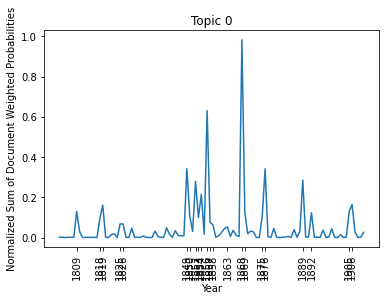

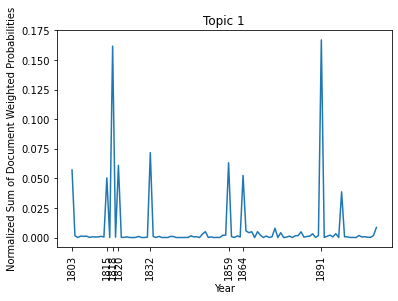

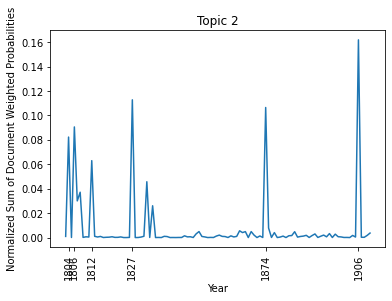

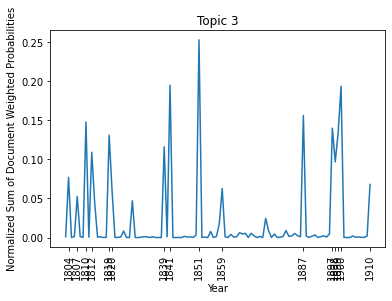

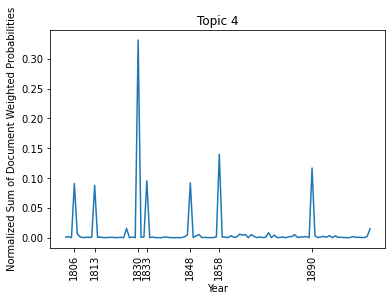

In [62]:
topic_docs_50 = get_doc_and_topic_data(model_50)
unique_terms = unique_topic_representations(model_50,50,10)
for topic_id in range(num_topics):
    print("Topic " + str(topic_id) + " Key Terms: ")
    print(unique_terms[topic_id])
    plot_probability_by_topic(model_50, topic_docs_50, doc_years, docs, unique_speech_years, topic_id)

Topic 0 Key Terms: 
['passing', 'thence', 'kent', 'norfolk', 'gibraltar', 'utility', 'print', 'facilitate', 'ten', 'space']
Topic 1 Key Terms: 
['liverpool', 'dock', 'nottinghamshire', 'park', 'yorkshire', 'palace', 'comply', 'intitled', 'disapprobation', 'insurance']
Topic 2 Key Terms: 
['gibraltar', 'commutation', 'door', 'regularity', 'lade', 'reverend', 'commute', 'clear', 'specify', 'somersetshire']
Topic 3 Key Terms: 
['physician', 'sec', 'animal', 'feeding', 'feeder', 'crew', 'fee', 'worship', 'exemption', 'voyage']
Topic 4 Key Terms: 
['reluctance', 'circulate', 'delicacy', 'involves', 'interview', 'crawford', 'departure', 'tagus', 'particulars', 'delegate']


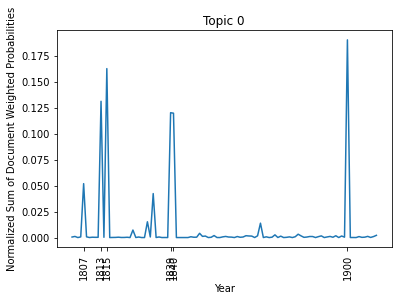

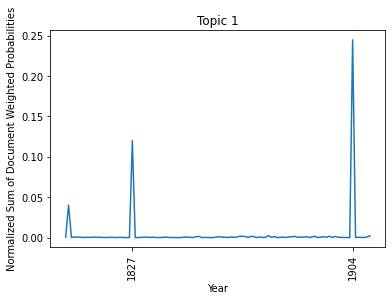

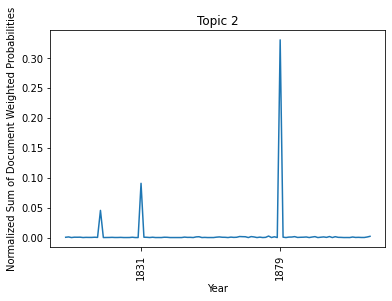

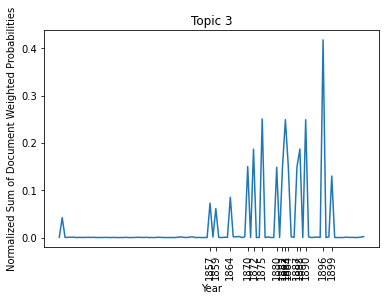

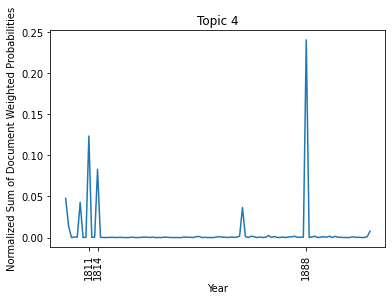

In [63]:
topic_docs_100 = get_doc_and_topic_data(model_100)
unique_terms = unique_topic_representations(model_100,50,10)
for topic_id in range(num_topics):
    print("Topic " + str(topic_id) + " Key Terms: ")
    print(unique_terms[topic_id])
    plot_probability_by_topic(model_100, topic_docs_100, doc_years, docs, unique_speech_years, topic_id)

### Time Series Generation
For use in ruptures change point detection algorithms

In [29]:
# generate time series to be used in change point detection algorithms
def get_time_series(model, topic_docs, doc_years, docs, unique_speech_years, topic_id):    
    doc_year = dict.fromkeys(unique_speech_years, 0)

    for doc_tup in topic_docs[topic_id]:
        year = doc_years[docs[doc_tup[0]]]
        doc_year[year] += doc_tup[1]

    final_doc_year = {k: v / year_docs[k] for k, v in doc_year.items()}
    years = list(final_doc_year.keys())
    xvals = [year for year in years if final_doc_year[year] > 0]
    T = list(final_doc_year.values())
    
    # magnify time_series
    T = [t*100 for t in T]
    return(np.expand_dims(T, 1))

In [30]:
# generate time series to be used in change point detection algorithms
def get_time_series_across_topics(model, topic_docs, doc_years, docs, unique_speech_years, num_topics_total):   
    total_time_series = [0] * len(unique_speech_years)
    for topic_id in range(num_topics_total):
        doc_year = dict.fromkeys(unique_speech_years, 0)

        for doc_tup in topic_docs[topic_id]:
            year = doc_years[docs[doc_tup[0]]]
            doc_year[year] += doc_tup[1]

        final_doc_year = {k: v / year_docs[k] for k, v in doc_year.items()}
        years = list(final_doc_year.keys())
        xvals = [year for year in years if final_doc_year[year] > 0]
        
        time_series = list(final_doc_year.values())
        
        total_time_series = [sum(x) for x in zip(total_time_series, time_series)]
        
    return total_time_series

### Visualization of Offline Change Point Detection Algorithm
Uses ruptures python package (https://ctruong.perso.math.cnrs.fr/ruptures-docs/build/html/index.html)

[5, 155, 330, 545, 605, 615, 640, 675, 850, 1000]


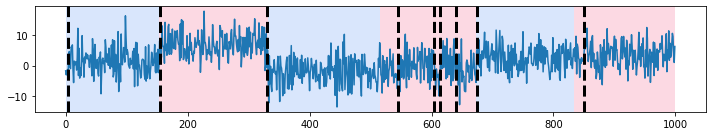

In [31]:
# simple example of how ruptures package works

# generate signal
n_samples, dim, sigma = 1000, 1, 4
n_bkps = 5  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

# detection
algo = rpt.Pelt(model="l1").fit(signal)
result = algo.predict(pen=10)
print(result)

# display
rpt.display(signal, bkps, result)
plt.show()

In [32]:
topic_docs_50 = get_doc_and_topic_data(model_50)

T0 = get_time_series(model_50, topic_docs_50, doc_years, docs, unique_speech_years, 0)
T1 = get_time_series(model_50, topic_docs_50, doc_years, docs, unique_speech_years, 1)
T2 = get_time_series(model_50, topic_docs_50, doc_years, docs, unique_speech_years, 2)

In [33]:
years = np.array(unique_speech_years).astype(np.int)

In [34]:
# determining right penalty value and number of breakpoints to be found without human discretion is difficult
model = "l2"
num_breakpoints = 5
pen = 10

In [35]:
# code courtesy of Morgan VandenBerg (May 7th, 2020 at 1am MST)
def graph_ruptures(T, topic_id):
    breakPointSets = []
   
    # Run Ruptures breakpoint detection with five different algorithms
    algo = rpt.Dynp(model=model, min_size=1, jump=1).fit(T)
    breakpoints = algo.predict(n_bkps = num_breakpoints)
    breakPointSets.append(breakpoints)
    
    algo = rpt.Pelt(model=model, min_size=1, jump=1).fit(T)
    breakpoints = algo.predict(pen = pen)
    breakPointSets.append(breakpoints)
   
    algo = rpt.Binseg(model=model, min_size=1).fit(T)
    breakpoints = algo.predict(n_bkps = num_breakpoints)
    breakPointSets.append(breakpoints)
   
    algo = rpt.BottomUp(model=model, min_size=1).fit(T)
    breakpoints = algo.predict(n_bkps = num_breakpoints)
    breakPointSets.append(breakpoints)
   
    algo = rpt.Window(model=model, width=5).fit(T)
    breakpoints = algo.predict(n_bkps = num_breakpoints)
    breakPointSets.append(breakpoints)
   
    algoNames = ['Dynp', 'Pelt', 'BinSeg', 'BottomUp', 'Window']
    algoColors = ['black', 'red', 'blue', 'green', 'purple']
    
    plt.figure(figsize=(20,6))
    plt.plot(years, T, color='gray')

    for (breakpointsSet, color) in zip(breakPointSets, algoColors):
        # RESCALE breakpoints to adjusted years axis
        breakpointsSet = np.array(breakpointsSet)
        breakpointsSet = breakpointsSet / len(years)
        breakpointsSet *= (np.max(np.array(years)) - np.min(np.array(years)))
        breakpointsSet += np.min(np.array(years))
        
        # Visualize the breakpoints
        for breakpoint in breakpointsSet:
            plt.axvline(breakpoint, color=color, linewidth=3.0, alpha=0.85, linestyle='--')
   
    # Formulate a plot legend
    legendPatches = []
    for name, color in zip(algoNames, algoColors):
        patch = mpatches.Patch(color=color, label=name)
        legendPatches.append(patch)
    plt.legend(handles=legendPatches)
   
   
    plt.title("Change Points" + ", Topic " + str(topic_id) + " (n: " + str(num_breakpoints) + ")")
    plt.xlabel("Year")
    plt.ylabel('Normalized Sum of Document Weighted Probabilities')
    plt.show()

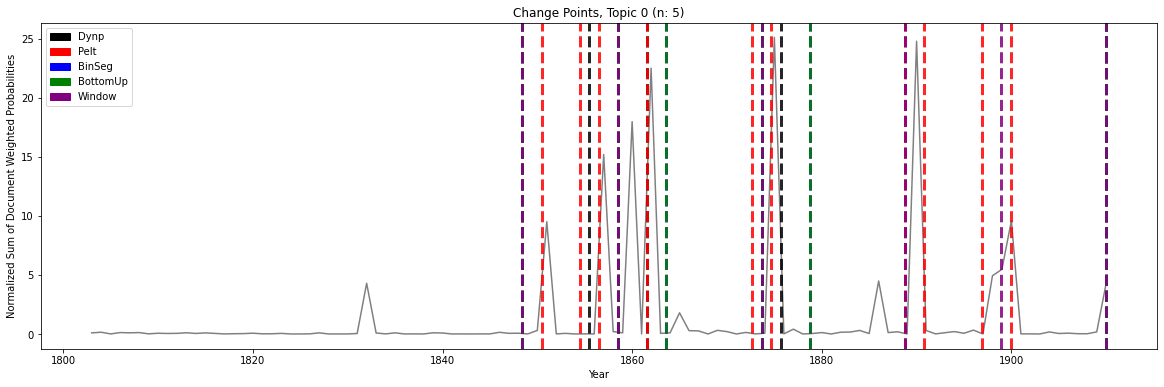

In [36]:
graph_ruptures(T0, 0)

Detected breakpoints: [45, 47, 51, 53, 55, 58, 69, 71, 85, 87, 93, 96, 106]


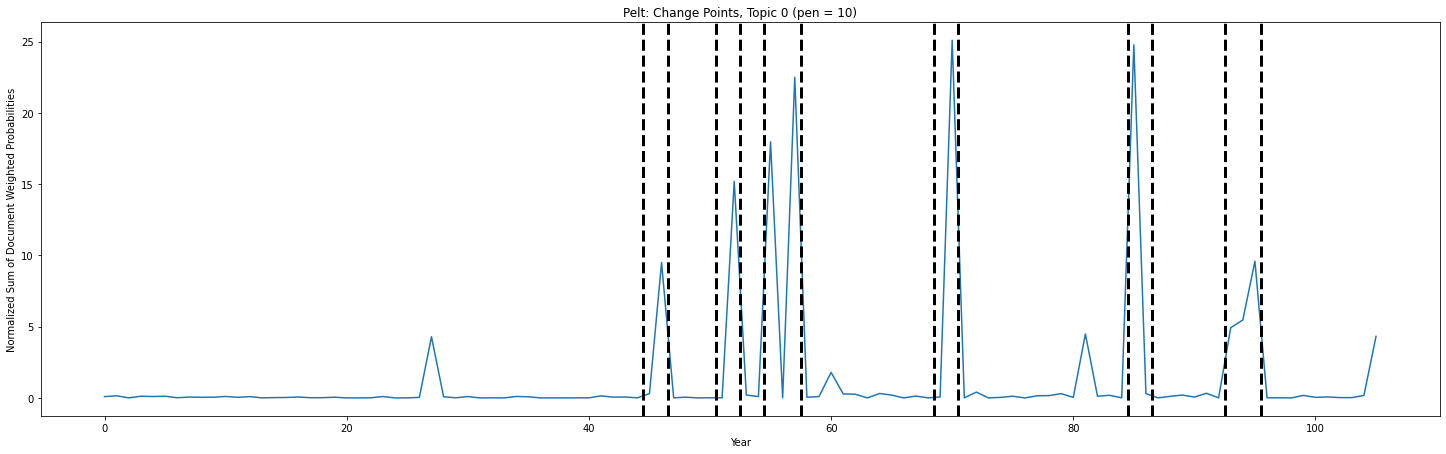

In [37]:
# Pelt only
algo = rpt.Pelt(model=model, min_size=1, jump=1).fit(T0)
my_bkps = algo.predict(pen=pen)
print("Detected breakpoints: " + str(my_bkps))

rpt.show.display(signal=T0, true_chg_pts=[], computed_chg_pts=my_bkps, figsize=(20, 6))
plt.title("Pelt: Change Points" + ", Topic 0" + " (pen = " + str(pen) + ")")
plt.xlabel("Year")
plt.ylabel('Normalized Sum of Document Weighted Probabilities')
plt.show()

Detected breakpoints: [60, 65, 75, 90, 95, 106]


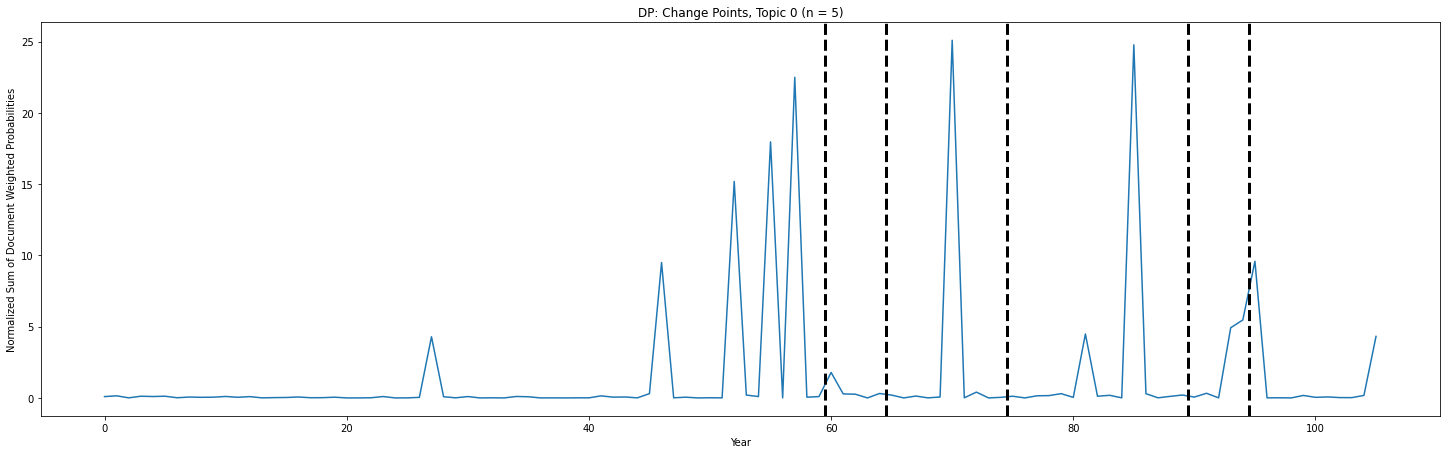

In [38]:
# change point detection using Dynp
model = "l1"  # "l2", "rbf"
algo = rpt.Dynp(model=model, min_size=1).fit(T0)
my_bkps = algo.predict(n_bkps=num_breakpoints)
print("Detected breakpoints: " + str(my_bkps))

# show results
rpt.show.display(signal=T0, true_chg_pts=[], computed_chg_pts=my_bkps, figsize=(20, 6))
plt.title("DP: Change Points" + ", Topic 0" + " (n = " + str(num_breakpoints) + ")")
plt.xlabel("Year")
plt.ylabel('Normalized Sum of Document Weighted Probabilities')
plt.show()

Detected breakpoints: [45, 55, 60, 70, 75, 106]


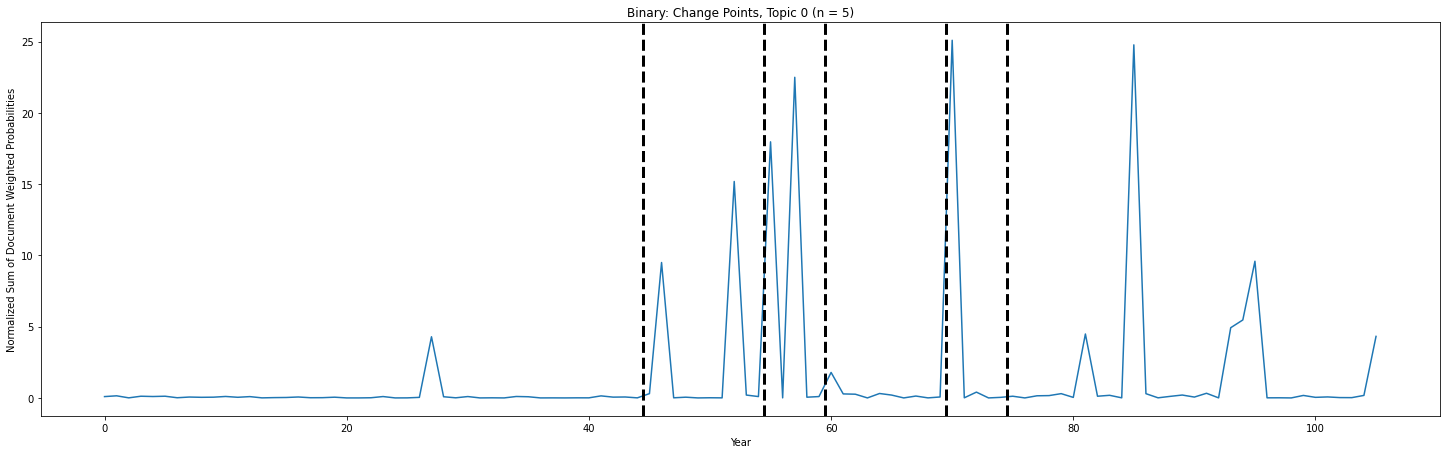

In [39]:
# change point detection using binary segmentation
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
algo = rpt.Binseg(model=model, min_size=1).fit(T0)
my_bkps = algo.predict(n_bkps=num_breakpoints)
print("Detected breakpoints: " + str(my_bkps))

# show results
rpt.show.display(signal=T0, true_chg_pts=[], computed_chg_pts=my_bkps, figsize=(20, 6))
plt.title("Binary: Change Points" + ", Topic 0" + " (n = " + str(num_breakpoints) + ")")
plt.xlabel("Year")
plt.ylabel('Normalized Sum of Document Weighted Probabilities')
plt.show()

Detected breakpoints: [45, 55, 60, 70, 75, 106]


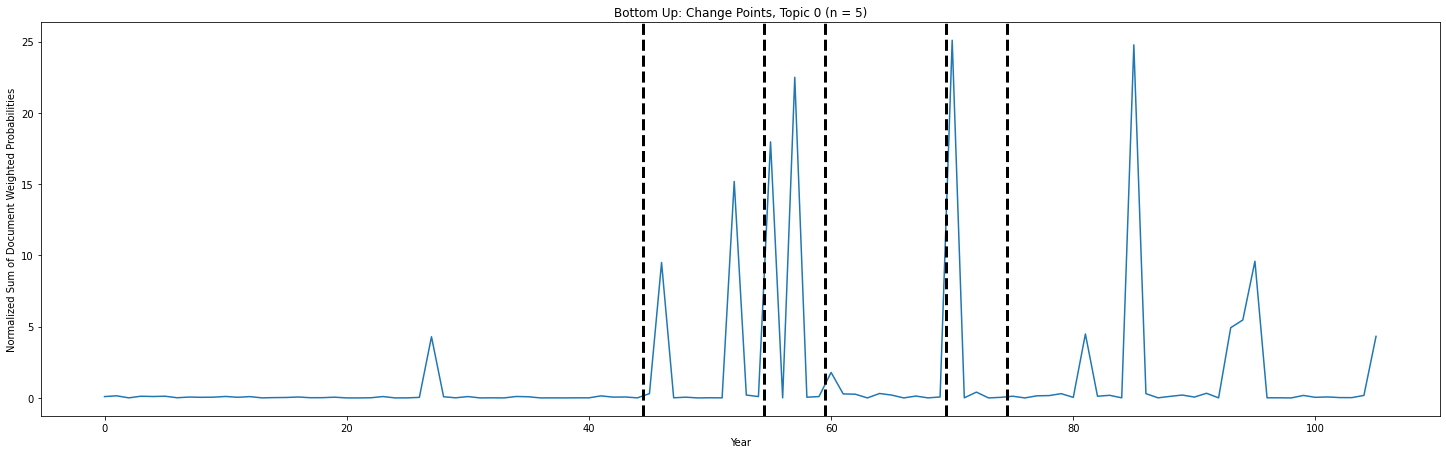

In [40]:
# change point detection using bottom up segmentation
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
algo = rpt.BottomUp(model=model, min_size=1).fit(T0)
my_bkps = algo.predict(n_bkps=num_breakpoints)
print("Detected breakpoints: " + str(my_bkps))

# show results
rpt.show.display(signal=T0, true_chg_pts=[], computed_chg_pts=my_bkps, figsize=(20, 6))
plt.title("Bottom Up: Change Points" + ", Topic 0" + " (n = " + str(num_breakpoints) + ")")
plt.xlabel("Year")
plt.ylabel('Normalized Sum of Document Weighted Probabilities')
plt.show()

Detected breakpoints: [15, 25, 45, 60, 70, 85, 100, 106]


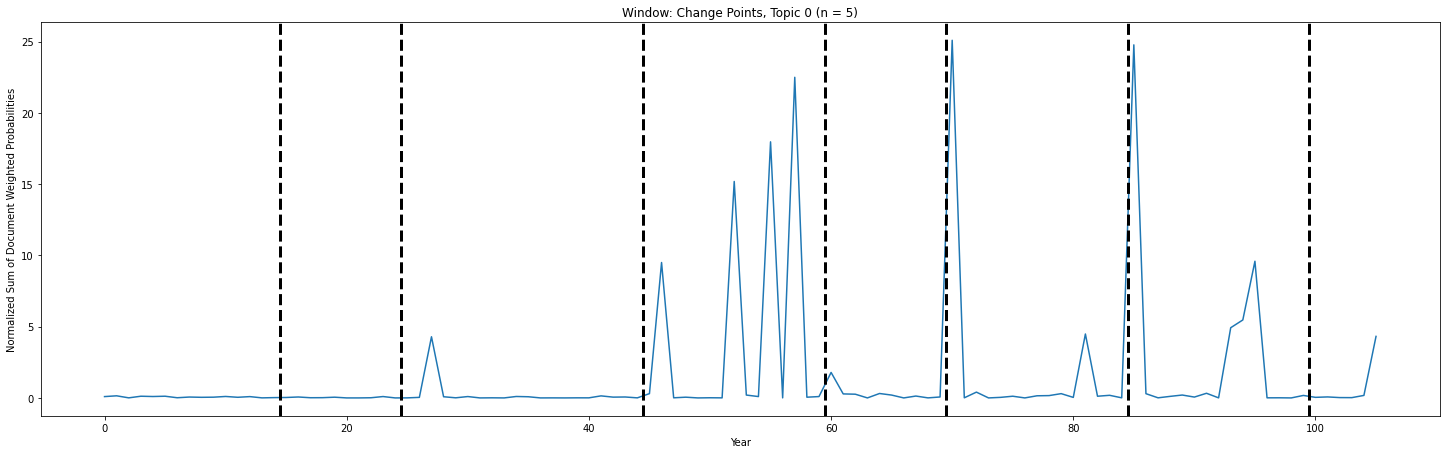

In [41]:
# change point detection using sliding window algorithm
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
algo = rpt.Window(width=10, model=model).fit(T0)
my_bkps = algo.predict(n_bkps=10)
print("Detected breakpoints: " + str(my_bkps))

# show results
rpt.show.display(signal=T0, true_chg_pts=[], computed_chg_pts=my_bkps, figsize=(20, 6))
plt.title("Window: Change Points" + ", Topic 0" + " (n = " + str(num_breakpoints) + ")")
plt.xlabel("Year")
plt.ylabel('Normalized Sum of Document Weighted Probabilities')
plt.show()

### Discontinuity Over Time
Use ruptures package to generate breakpoints and sum frequency of breakpoints for given year over all topics

In [42]:
def generate_discontinuities(T, first_year, show_results=False):
    # change point detection using Pelt
    model = "l2"
    algo = rpt.Pelt(model=model, min_size=1, jump=1).fit(T)
    breakpoints = algo.predict(pen=10)
    
    if show_results == True:
        rpt.show.display(signal=T, true_chg_pts=[], computed_chg_pts=breakpoints, figsize=(20, 6))
        plt.show()
    
    return [bkp + first_year for bkp in breakpoints]

In [43]:
first_year = int(unique_speech_years[0])
all_time_series = []
all_bkps = []
for topic_id in range(50):
    T = get_time_series(model_50, topic_docs_50, doc_years, docs, unique_speech_years, topic_id)
    bkps = generate_discontinuities(T, first_year)
    
    all_time_series.append(T)
    all_bkps.append(bkps)

In [44]:
discontinuities_by_year = {}
for year in unique_speech_years:
    discontinuities_by_year[year] = 0
     
discontinuities_topics_by_year = {}
for year in unique_speech_years:
    discontinuities_topics_by_year[year] =[]

In [45]:
for topic_id, topic_bkps in enumerate(all_bkps):
    for bkp in topic_bkps:
        if (str(bkp) in unique_speech_years):
            discontinuities_by_year[str(bkp)] += 1
            discontinuities_topics_by_year[str(bkp)].append(topic_id)

In [46]:
# take a look at topics that might be similar across some years (using visual inspection)
unique_terms = unique_topic_representations(model_50, 50, 5)
topics_to_look_at = [3, 8, 12, 18, 20, 33, 44]
for topic_id in topics_to_look_at:
    print(topic_id)
    print(unique_terms[topic_id])

3
['ratification', 'peninsula', 'clerk', 'magistracy', 'blame']
8
['lunatic', 'asylum', 'dividend', 'west', 'ration']
12
['colonies', 'dissatisfaction', 'muscat', 'armistice', 'divide']
18
['west', 'commutation', 'jan', 'transmit', 'hammond']
20
['malt', 'barley', 'suitor', 'sequestration', 'consumer']
33
['proclamation', 'prisoner', 'rassam', 'couza', 'alexander']
44
['clasp', 'fire', 'balaklava', 'wear', 'crimea']


['1805', '1807', '1809', '1811', '1813', '1834', '1839', '1850', '1882', '1907', '1909']


Text(0.5, 1.0, 'Discontinuity Across Topics By Year')

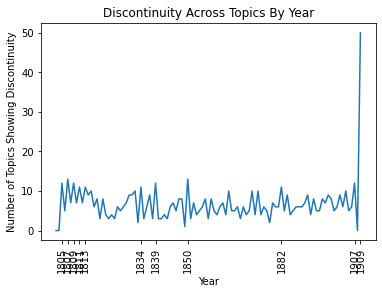

In [65]:
# discontinuality 

# plt.figure(topic_num)
x = unique_speech_years[:-1]
y = list(discontinuities_by_year.values())[:-1]

xvals = [year for (year, freq) in zip(x, y) if freq > 10]
print(xvals)

plt.plot(x, y)
plt.xticks(xvals, rotation=90)
plt.xlabel('Year')
plt.ylabel('Number of Topics Showing Discontinuity')
plt.title('Discontinuity Across Topics By Year')

### Conclusions: 

Some models perform similarly if parameters are tuned correctly (number of breakpoints, penalty value). Use l2 loss function. Unsupervised learning means that the algorithms are pretty sensitive to parameters (penalty value, number of breakpoints, width of Window, etc.). Penalty value has to be pretty low in order to get any sort of breakpoints.

### DTM Model (Gensim)
These models take too long to run on the Lyle genuse servers. Could be an approach for future work.

In [ ]:
# attempt at Dynamic Topic Modelling from https://radimrehurek.com/gensim/models/wrappers/dtmmodel.html
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.wrappers import DtmModel

path_to_dtm_binary = "./dtm/dtm/main"
model = DtmModel(
    path_to_dtm_binary, corpus=corpus, id2word=dictionary,
    time_slices=[1] * len(corpus)
)

In [ ]:
# attempt at LDA Sequence Model from https://radimrehurek.com/gensim/models/ldaseqmodel.html
# get time slices
chunk = list(year_docs.values())

from gensim.models import LdaSeqModel
ldaseq = LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=chunk, num_topics=5)

## III. Examining Effects of LDA Stability on Results
Uses Jaccard similarity coefficient to compare topic sets

In [48]:
def compare_topic_sets(t_prime, u_prime, print_topics=False):
    # do topic assignments between sets
    max_similarities = []
    for idx1, T in enumerate(t_prime):
        max_similarity = (None, 0)
        for idx2, U in enumerate(u_prime):
            t = set([token for token, prob in T])
            u = set([token for token, prob in U])
            
            # calculate jaccard coefficient between topics and store highest
            jaccard = len(t & u) / len(t | u)
            if jaccard > max_similarity[1]:
                max_similarity = (idx2, jaccard)

        max_similarities.append(max_similarity)
        
    ms = np.array(max_similarities)
    num_topics = np.shape(ms)[0]
    
    if print_topics:
        print("Original Topic Assignment")
        for idx in range(0, num_topics):
            print(str(idx) + ": " + str(int(ms[idx][0])) + ", " + str(ms[idx][1]))
        print()
    
    # take care of imperfect matches
    u_vals = np.unique(ms[:,0])
    for val in u_vals:
        same_topic = ms[ms[:,0] == val]
        if len(same_topic) > 1:
            max_sim = np.amax(same_topic[:,1])
            ms[(ms[:,0] == val) & (ms[:,1] != max_sim),1] = 0
    
    if print_topics:
        print("New Topic Assignment")
        for idx in range(0, num_topics):
            print(str(idx) + ": " + str(int(ms[idx][0])) + ", " + str(ms[idx][1]))
        print()
    
    topics_used = len(u_vals) / len(u_prime)
    similarity_sum = np.sum(ms[:,1])
    print("Topics Used: " + str(topics_used))
    print("Similarity Sum: " + str(similarity_sum))
    print()

In [49]:
runs = 10
k = 25
num_topics = 50

prev_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha='auto')

prev_topic_terms = []
for idx in range(0, num_topics):
    topic_terms = prev_model.show_topic(idx, topn=k)
    prev_topic_terms.append(topic_terms)

for idx in range(1, runs):
    model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha='auto')
    
    new_topic_terms = []
    for idx in range(0, num_topics):
        topic_terms = model.show_topic(idx, topn=k)
        new_topic_terms.append(topic_terms)
        
    # get jaccard similarity
    compare_topic_sets(prev_topic_terms, new_topic_terms)
    
    prev_topic_terms = new_topic_terms

Topics Used: 0.4
Similarity Sum: 11.430752405537985

Topics Used: 0.54
Similarity Sum: 18.78157515790425

Topics Used: 0.42
Similarity Sum: 15.729050744071518

Topics Used: 0.5
Similarity Sum: 17.343744425656045

Topics Used: 0.38
Similarity Sum: 15.013887932899252

Topics Used: 0.42
Similarity Sum: 16.63102894864084

Topics Used: 0.42
Similarity Sum: 14.703734643437597

Topics Used: 0.44
Similarity Sum: 15.925434649539863

Topics Used: 0.48
Similarity Sum: 16.43560106821574



### Notes

* Different similarity measures besides the Jaccard coefficient might be used in order to distinguish between topic sets. We explored the use of word embedding-based similarity and aggregated embedding-based similarity in other techniques.

### Current Conclusions

Unsupervised learning via change point detection using text documents is difficult.
* LDA is rather unstable - you'll get different topic representations from run to run, and there might be considerable overlap between topics, which makes it difficult to obtain consistent results.
* Change point detection is also an evolving body of work - there are different algorithms, loss functions, parameters, and assumptions that need to be made. Parameters must be chosen carefully.

### Further Work

* Cross-reference with actual history elements to determine accuracy - there is some historical context
* Other approaches to utilizing the generated time series - anomaly detection algorithms (density / clustering / support vector machine-based anomaly detection methods)